# 5.1 Post-prediction Exploration
In this notebook we'll see an example of post-prediction exploration method which uses weighted sampling to re-rank the predicted list order, allowing lower-ranked items to surface up. Still, as the re-rankin method depends on the weight of each item, on average the higher ranked items are displayed higher in the list than lower-ranked items, not entirely ignoring the ranking model's predictions.

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_recommenders as tfrs

Loading data and metadata, and converting to to Datasets.

In [2]:
train_df = pd.read_csv('../local_data/train_data.csv', header=0)
test_df = pd.read_csv('../local_data/test_data.csv', header=0)
with open('../local_data/metadata.json', 'r') as f:
    metadata = json.load(f)

In [3]:
all_users = [str(int(i)) for i in metadata['users']]
all_movies = [str(int(i)) for i in metadata['movies']]
all_cities = metadata['cities']
all_states = metadata['states']
all_ages = [str(int(i)) for i in metadata['ages']]
all_occupations = [str(int(i)) for i in metadata['occupations']]
all_genres = metadata['genres']
title_emb_len = metadata['title_emb_size']
na_value = metadata['string_na']

In [4]:
def convert_to_dataset(df):
    movie_features = ['movie', 'title_emb', 'genres', 'movie_year', 'rating']
    d = {k:v.to_numpy() for k,v in dict(df).items()}
    d['genres'] = np.transpose(np.array([d[x] for x in all_genres]))
    d['title_emb'] = np.transpose(np.array([d[f'title_emb_{i}'] for i in range(title_emb_len)]))
    for x in all_genres + [f'title_emb_{i}' for i in range(title_emb_len)]:
        d.pop(x)
    d = {k:(np.expand_dims(v, axis=1) if k in movie_features else v) for k,v in d.items()}
    return tf.data.Dataset.from_tensor_slices(d)

train_dataset = convert_to_dataset(train_df)
test_dataset = convert_to_dataset(test_df)

Loading our ranking model from project #3.2:

In [5]:
class RatingPredictionModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        
        tower_last_layer_size = 50
        large_embedding_size = 25
        medium_embedding_size = 5
        small_embedding_size = 3
        
        # User tower
        
        self.user_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='user_input')
        self.user_sl = tf.keras.layers.StringLookup(vocabulary=all_users, name='user_string_lookup')(self.user_input)
        self.user_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_users)+1, large_embedding_size, name='user_emb')(self.user_sl), axis=1)
        
        self.city_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='city_input')
        self.city_sl = tf.keras.layers.StringLookup(vocabulary=all_cities, mask_token=na_value, name='city_string_lookup')(self.city_input)
        self.city_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_cities)+2, medium_embedding_size, name='city_emb')(self.city_sl), axis=1)
        
        self.state_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='state_input')
        self.state_sl = tf.keras.layers.StringLookup(vocabulary=all_states, mask_token=na_value, name='state_string_lookup')(self.state_input)
        self.state_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_states)+2, small_embedding_size, name='state_emb')(self.state_sl), axis=1)
        
        self.age_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='age_input')
        self.age_sl = tf.keras.layers.StringLookup(vocabulary=all_ages, num_oov_indices=0, name='age_string_lookup')(self.age_input)
        self.age_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_ages), small_embedding_size, name='age_emb')(self.age_sl), axis=1)
        
        self.occupation_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='occupation_input')
        self.occupation_sl = tf.keras.layers.StringLookup(vocabulary=all_occupations, num_oov_indices=0, name='occupation_string_lookup')(self.occupation_input)
        self.occupation_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_occupations), small_embedding_size, name='occupation_emb')(self.occupation_sl), axis=1)
        
        self.gender_input = tf.keras.Input(shape=(1,), name='gender_input')
        self.hour_input = tf.keras.Input(shape=(1,), name='hour_input')
        self.day_input = tf.keras.Input(shape=(1,), name='day_input')
        self.month_input = tf.keras.Input(shape=(1,), name='month_input')
        
        self.user_merged = tf.keras.layers.concatenate([self.user_emb, self.city_emb, self.state_emb, self.age_emb, 
                                                        self.occupation_emb, self.gender_input, self.hour_input,
                                                        self.day_input, self.month_input], 
                                                       axis=-1, name='user_merged')
        self.user_dense = tf.keras.layers.Dense(100, activation='relu', name='user_dense')(self.user_merged)
        self.user_last_layer = tf.keras.layers.Dense(tower_last_layer_size, activation='relu', name='user_last_layer')(self.user_dense)
        
        # Movie tower
        
        self.movie_input = tf.keras.Input(shape=(None,1), dtype=tf.string, name='movie_input')
        self.movie_sl = tf.keras.layers.StringLookup(vocabulary=all_movies, name='movie_string_lookup')(self.movie_input)
        self.movie_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_movies)+1, large_embedding_size, name='movie_emb')(self.movie_sl), axis=2)
        
        self.title_input = tf.keras.Input(shape=(None,title_emb_len), name='title_input')
        self.title_dense = tf.keras.layers.Dense(title_emb_len, activation='softmax', name='title_softmax')(self.title_input)
        
        self.genres_input = tf.keras.Input(shape=(None,len(all_genres)), name='genres_input')
        self.year_input = tf.keras.Input(shape=(None,1), name='year_input')
        
        self.movie_merged = tf.keras.layers.concatenate([self.movie_emb, self.title_dense, self.genres_input, self.year_input] ,axis=-1, name='movie_merged')
        self.movie_dense = tf.keras.layers.Dense(100, activation='relu', name='movie_dense')(self.movie_merged)
        self.movie_last_layer = tf.keras.layers.Dense(tower_last_layer_size, activation='relu', name='movie_last_layer')(self.movie_dense)
        
        # Combining towers
        
        self.towers_multiplied = tf.keras.layers.Multiply(name='towers_multiplied')([tf.expand_dims(self.user_last_layer, axis=2), 
                                                                                     tf.transpose(self.movie_last_layer, perm=[0,2,1])])
        self.towers_dense1 = tf.keras.layers.Dense(40, activation='relu', name='towers_dense1')(tf.transpose(self.towers_multiplied, perm=[0,2,1]))
        self.towers_dense2 = tf.keras.layers.Dense(20, activation='relu', name='towers_dense2')(self.towers_dense1)
        self.output_node = tf.keras.layers.Dense(1, name='output_node')(self.towers_dense2)
        
        # Model definition
        
        self.model = tf.keras.Model(inputs={'user': self.user_input, 
                                            'city': self.city_input,
                                            'state': self.state_input,
                                            'age': self.age_input,
                                            'occupation': self.occupation_input,
                                            'gender': self.gender_input,
                                            'hour': self.hour_input,
                                            'day': self.day_input,
                                            'month': self.month_input,
                                            'movie': self.movie_input,
                                            'title': self.title_input,
                                            'genres': self.genres_input,
                                            'year': self.year_input
                                            }, 
                                    outputs=self.output_node)
        
        self.task = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
        
    def call(self, features):
        return self.model({'user': tf.strings.as_string(features["user"]), 
                           'city': features["city"], 
                           'state': features["state"],
                           'age': tf.strings.as_string(features["age"]),
                           'occupation': tf.strings.as_string(features["occupation"]), 
                           'gender': features["gender"],
                           'hour': features["hour"],
                           'day': features["day"],
                           'month': features["month"],
                           'movie': tf.strings.as_string(features["movie"]),
                           'title': features["title_emb"],
                           'genres': features["genres"],
                           'year': features["movie_year"]
                           })
    
    def compute_loss(self, features_dict, training):
        labels = features_dict["rating"]
        predictions = self(features_dict)
        return self.task(labels=labels, predictions=predictions)

In [6]:
model = RatingPredictionModel()
model.compile()
model.load_weights('../project_3/weights_3_2/p32')

Next we select a user and 10 movies to use as test examples. In order to get movies with varying predictions, I decided to predict the ratings of 50 movies, and consider the top 5 and lowest 5 ranked movies as my test example.

In [7]:
user_features = ['user','city','state','gender','age','occupation','hour','day','month']

def test_movies_dict(n=50):
    df = test_df.iloc[:n,:].drop(user_features+['rating'], axis=1)
    d = {k:v.to_numpy() for k,v in dict(df).items()}
    d['genres'] = np.transpose(np.array([d[x] for x in all_genres]))
    d['title_emb'] = np.transpose(np.array([d[f'title_emb_{i}'] for i in range(title_emb_len)]))
    for x in all_genres + [f'title_emb_{i}' for i in range(title_emb_len)]:
        d.pop(x)
    d.update({k:np.expand_dims(np.vstack(v), axis=0) for k,v in d.items()})
    return d

def test_user_dict():
    test_user = dict(test_df[user_features].iloc[0])
    return {k:np.array([v]) for k,v in test_user.items()}

prediction_data = test_user_dict()
prediction_data.update(test_movies_dict())
predicted_ratings = model.predict(prediction_data)

movies_array = np.zeros((predicted_ratings.shape[1], 2))
for i in range(predicted_ratings.shape[1]):
    movies_array[i,0] = prediction_data['movie'][0,i,0]
    movies_array[i,1] = predicted_ratings[0,i,0]
    
movies_array = movies_array[np.argsort(-movies_array[:,1])]
movies_array = np.concatenate((movies_array[:5], movies_array[-5:]))

# first column = movie ID, second column = predicted rating
movies_array

array([[8.58000000e+02, 4.17399645e+00],
       [9.23000000e+02, 4.07758141e+00],
       [9.08000000e+02, 4.07647324e+00],
       [2.02800000e+03, 4.07531071e+00],
       [2.57100000e+03, 4.02859879e+00],
       [4.29000000e+02, 2.85468149e+00],
       [2.71000000e+03, 2.76051688e+00],
       [2.80500000e+03, 2.67429352e+00],
       [1.88200000e+03, 2.17205715e+00],
       [7.37000000e+02, 1.94682717e+00]])

The code below reranks the list using weighted sampling _(not sure why this is weighted sampling? See [this blogpost][1] (also available [here][2]))_. This process is done 24 times, and results are displayed in the heatmap below, where each item (row) is shown the index it recieved in each weighted sampling (0 being the top item of the list). We can clearly see that while each item recieves very different ranking position, on average the original ranking is more or less preserved.

[1]: https://shakedzy.medium.com/going-old-school-designing-algorithms-for-fast-weighted-sampling-in-production-c48fc1f40051
[2]: https://blog.taboola.com/going-old-school-designing-algorithms-fast-weighted-sampling-production/

<AxesSubplot:>

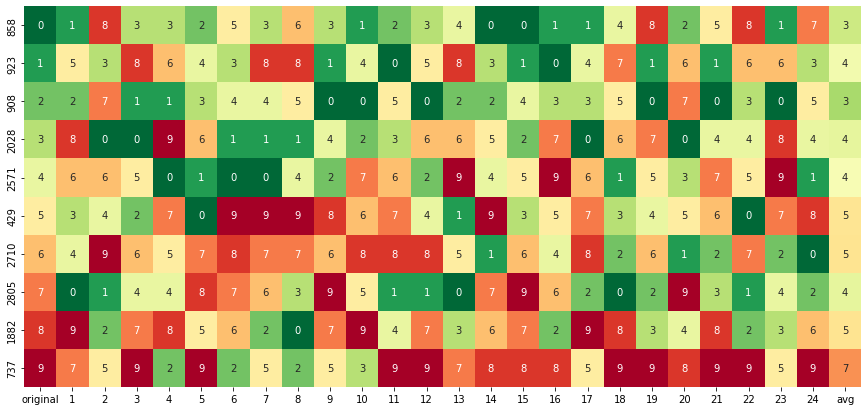

In [8]:
def weighted_sampling(movies_array):
    sampled_weights = np.vectorize(lambda x: np.log(np.random.rand())/x)(movies_array[:,1])
    return movies_array[:,0][np.argsort(-sampled_weights)]

num_tests = 25
results = np.zeros((movies_array.shape[0], num_tests))
results[:,0] = movies_array[:,0]
for i in range(1, num_tests):
    results[:,i] = weighted_sampling(movies_array)
    
heatmap_array = np.zeros_like(results)
for i,m in enumerate(movies_array[:,0]):
    idx = np.argwhere(results==m) 
    heatmap_array[i,:] = idx[np.argsort(idx[:,1])][:,0]
    
heatmap_df = pd.DataFrame(heatmap_array, index=[int(i) for i in movies_array[:,0]])
heatmap_df.rename(columns={0: 'original'}, inplace=True)
heatmap_df['avg'] = heatmap_df.apply(lambda row: row.drop('original').mean(), axis=1)
plt.figure(figsize=(15,7))
sns.heatmap(heatmap_df, annot=True, fmt='.0f', cbar=False, cmap='RdYlGn_r')